##### Josh Seward & Weston Averill
##### 5/4/2022
##### CPSC322, Spring 2022
##### MLB All-Star Predictor

# MLB All-Star Predictor Final Project Technical Report

### Introduction

For this project, we used data from Kaggle's "History of Baseball" dataset where we selected three different files of data for analysis. The goal was to use our classifiers with binary classification and attempt to predict whether or not an unseen instance is an MLB all-star. After puting the data through our dummy, naive-bayes, and random forest classifiers, we learned *TODO: insert best classifier* performed the best. 

### Data Analysis

The three main data files used for this project were 'Allstar.txt', 'Batting.txt', and 'Fielding.txt'. The first step of the data cleaning was to join the batting stats and fielding stats so that each instance(row) in the data would represent one players stats. To do this, we performed an inner join on these two datasets with the key being playerID and yearID. We thought this would correctly give us one instance for each player for each year they played, but we were still getting multiple rows for a player for the same year. The reason this was happening was because the dataset had instances for each of the teams they played on. For example, if a player played for three teams in 2015, after our join, our table would have three instaces with year 2015, one for each team. To solve this problem, we added each corresponding attribute value together to create one instace, that now represents the players' stats for that year, which is what we wanted. 

After getting player stats for each specific year, we used the 'Allstar.txt' data to add a class label to each of our instances. If a playerID and yearID in our data matched to an instance in the Allstar data, the class label would be set to true, false otherwise. 

After doing the previous steps, we now have clean data for MLB players from 2000-2015 that represents their stats, and their all-star status. In baseball, the number of non all-stars is much greater than the number of all-stars. In order to be able to actually see how well our classifiers make predicions, we had to down-sample the amount of non all-stars from about 19,000 to around 500, which is the same number of all-stars in the dataset. This gave us an even distribution of class labels. 

Our final data file has 16 attributes with 'class' being used as the class label. Joining the datasets gave us many attributes, but we decided to only include attributes that were the most useful and common in baseball. 

The below code cells implement steps described to clean the data. 

In [1]:
# some useful mysklearn package import statements and reloads
import importlib
import os
import copy
import mysklearn.myutils as myutils
import random
importlib.reload(myutils)
# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable as mypytable
importlib.reload(mypytable)

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

# put data into a table
path = os.path.join("output_data", "batting_fielding_joined.txt")
batting_fielding_joined = mypytable.MyPyTable().load_from_file(path)
batting_fielding_joined.drop_column("playerID")
table_copy = copy.deepcopy(batting_fielding_joined.data)
# print(len(table_copy))
# batting_fielding_joined.drop_column('GZ')
# print(len(batting_fielding_joined.column_names))
# batting_fielding_joined.drop_column('GS')

# column = batting_fielding_joined.get_column('E', True)
# cutoffs = myutils.compute_equal_width_cutoffs(column, 8)
# print(cutoffs)
# new_list = []
# for value in column:
#     if value == max(column):
#         new_list.append(8)
#     else:
#         for i in range(len(cutoffs)-1):
#             if cutoffs[i] <= value < cutoffs[i + 1]:
#                 new_list.append(i+1)

# print(new_list)
# for i, row in enumerate(table_copy):
#     # row[17] = str(new_list[i])
#     row[1] = str(row[1])
# batting_fielding_joined.data = table_copy

for row in table_copy:
    for i in range(len(row)):
        row[i] = str(row[i])
# print(table_copy)
# batting_fielding_joined.data = table_copy
# batting_fielding_joined.save_to_file(path)
# print(table_copy)

rows_of_allstar = []
rows_of_nonallstar = []
for row in table_copy:
    if row[-1] == "true":
        rows_of_allstar.append(row)
    else:
        rows_of_nonallstar.append(row)
# print(len(rows_of_allstar), len(rows_of_nonallstar))
# print(rows_of_nonallstar[1])
random.shuffle(rows_of_nonallstar)
# print(rows_of_nonallstar[1])
new_non_allstar = []
for i in range(524):
    new_non_allstar.append(rows_of_nonallstar[i])
table_copy = rows_of_allstar + new_non_allstar
random.shuffle(table_copy)


# take the classes col from table and put into y table
y = []
for instance in table_copy:
    y.append(instance[-1])
    del(instance[-1])

# # create another copy of the dataset
table_copy_classifier = copy.deepcopy(table_copy)

# # get train and test indices
train_indices, test_indices = myevaluation.stratified_kfold_cross_validation(table_copy, y, 10, 0, False)
new_table = []
indices_to_train = []
indices_to_test = []
y_train = []
predictions = []
for i in range(len(train_indices)):
    for index in train_indices[i]:
        indices_to_train.append(table_copy_classifier[index])
        y_train.append(y[index])
    for index in test_indices[i]:
        indices_to_test.append(table_copy_classifier[index])
    dummy_classifier = MyDummyClassifier()
    dummy_classifier.fit(indices_to_train, y_train)
    predictions.append(dummy_classifier.predict(indices_to_test))
    indices_to_train = []
    indices_to_test = []
    y_train = []
y_true = []
y_pred = []
for instance in test_indices:
    for index in instance:
        y_true.append(y[index])
for instance in predictions:
    for prediction in instance:
        y_pred.append(prediction)

accuracy = myevaluation.accuracy_score(y_true, y_pred, True)
precision = myevaluation.binary_precision_score(y_true, y_pred, ["false", "true"], "true")
recall = myevaluation.binary_recall_score(y_true, y_pred, ["false", "true"], "true")
f1 = myevaluation.binary_f1_score(y_true, y_pred, ["false", "true"], "true")
matrix = myevaluation.confusion_matrix(y_true, y_pred, ["false", "true"])
# print(f'Accuracy: {accuracy}')
# print(f'Error Rate: {1-accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1 measure: {f1}')
# print(f'Confusion Matrix: {matrix}')


ModuleNotFoundError: No module named 'sqlalchemy'

In [10]:
# some useful mysklearn package import statements and reloads
import importlib
import os
import copy
import mysklearn.myutils as myutils
import random
importlib.reload(myutils)
# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable as mypytable
importlib.reload(mypytable)

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

# put data into a table
path = os.path.join("output_data", "batting_fielding_joined.txt")
batting_fielding_joined = mypytable.MyPyTable().load_from_file(path)
batting_fielding_joined.drop_column("playerID")
table_copy = copy.deepcopy(batting_fielding_joined.data)
# print(len(table_copy))
# batting_fielding_joined.drop_column('GZ')
# print(len(batting_fielding_joined.column_names))
# batting_fielding_joined.drop_column('GS')

# column = batting_fielding_joined.get_column('E', True)
# cutoffs = myutils.compute_equal_width_cutoffs(column, 8)
# print(cutoffs)
# new_list = []
# for value in column:
#     if value == max(column):
#         new_list.append(8)
#     else:
#         for i in range(len(cutoffs)-1):
#             if cutoffs[i] <= value < cutoffs[i + 1]:
#                 new_list.append(i+1)

# print(new_list)
# for i, row in enumerate(table_copy):
#     # row[17] = str(new_list[i])
#     row[1] = str(row[1])
# batting_fielding_joined.data = table_copy

for row in table_copy:
    for i in range(len(row)):
        row[i] = str(row[i])
# print(table_copy)
# batting_fielding_joined.data = table_copy
# batting_fielding_joined.save_to_file(path)
# print(table_copy)

rows_of_allstar = []
rows_of_nonallstar = []
for row in table_copy:
    if row[-1] == "true":
        rows_of_allstar.append(row)
    else:
        rows_of_nonallstar.append(row)
# print(len(rows_of_allstar), len(rows_of_nonallstar))
# print(rows_of_nonallstar[1])
random.shuffle(rows_of_nonallstar)
# print(rows_of_nonallstar[1])
new_non_allstar = []
for i in range(524):
    new_non_allstar.append(rows_of_nonallstar[i])
table_copy = rows_of_allstar + new_non_allstar
random.shuffle(table_copy)


# take the classes col from table and put into y table
y = []
for instance in table_copy:
    y.append(instance[-1])
    del(instance[-1])

# # create another copy of the dataset
table_copy_classifier = copy.deepcopy(table_copy)

# # get train and test indices
train_indices, test_indices = myevaluation.stratified_kfold_cross_validation(table_copy, y, 10, 0, False)
new_table = []
indices_to_train = []
indices_to_test = []
y_train = []
predictions = []
for i in range(len(train_indices)):
    for index in train_indices[i]:
        indices_to_train.append(table_copy_classifier[index])
        y_train.append(y[index])
    for index in test_indices[i]:
        indices_to_test.append(table_copy_classifier[index])
    tree_classifier = MyDecisionTreeClassifier()
    tree_classifier.fit(indices_to_train, y_train)
    predictions.append(tree_classifier.predict(indices_to_test))
    indices_to_train = []
    indices_to_test = []
    y_train = []
y_true = []
y_pred = []
for instance in test_indices:
    for index in instance:
        y_true.append(y[index])
for instance in predictions:
    for prediction in instance:
        y_pred.append(prediction)

accuracy = myevaluation.accuracy_score(y_true, y_pred, True)
precision = myevaluation.binary_precision_score(y_true, y_pred, ["false", "true"], "true")
recall = myevaluation.binary_recall_score(y_true, y_pred, ["false", "true"], "true")
f1 = myevaluation.binary_f1_score(y_true, y_pred, ["false", "true"], "true")
matrix = myevaluation.confusion_matrix(y_true, y_pred, ["false", "true"])
# print(f'Accuracy: {accuracy}')
# print(f'Error Rate: {1-accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1 measure: {f1}')
# print(f'Confusion Matrix: {matrix}')


Accuracy: 0.6708015267175572
Error Rate: 0.3291984732824428
Precision: 0.6584070796460177
Recall: 0.7099236641221374
F1 measure: 0.6831955922865014
Confusion Matrix: [[331, 193], [152, 372]]


In [2]:
import importlib
import os
import copy
importlib.reload(myutils)
from mysklearn.mypytable import MyPyTable

fname = os.path.join("input_data", "AllstarFull.csv")
allstar_table = MyPyTable().load_from_file(fname)
# print(allstar_table.data)

fname = os.path.join("input_data", "Batting.csv")
# batting_table = MyPyTable().load_from_file(fname)
# print(batting_table.data)

fname = os.path.join("input_data", "Fielding.csv")
# fielding_table = MyPyTable().load_from_file(fname)
# print(fielding_table)

fname = os.path.join("input_data", "player.csv")
player_table = MyPyTable().load_from_file(fname)
# print(fielding_table)

# ''' first drop rows from table if they are not in year 2000-2015 '''
# use this code for all three datasets
# lst_of_indices = [i for i in range(3916)]
# allstar_table.drop_rows(lst_of_indices)
# allstar_table_clean = os.path.join("output_data", "Allstar.txt")
# allstar_table.save_to_file(allstar_table_clean)






#### testing for cleaning

In [4]:
import importlib
import os
import copy
importlib.reload(myutils)
importlib.reload(mypytable)

header = ['att1', 'att2']
data = [['weston', 1], 
        ['mike', 2]]

header2 = ['att1', 'att4', 'att5', 'att6']
data2 = [['weston', 2000,3, 30],
         ['weston', 2000, 3, 40]]

table1 = mypytable.MyPyTable(header, data)
table2 = mypytable.MyPyTable(header2, data2)

new_table = []
primarykey_list = []
for row in table2.data:
    key = str(row[0]) + str(row[1])
    if key not in primarykey_list:
        primarykey_list.append(key)
# print(primarykey_list)

for key in primarykey_list:
    temp_table = []
    for instance in table2.data:
        temp_key = str(instance[0]) + str(instance[1])
        if temp_key == key:
            temp_table.append(instance)
    if len(temp_table) == 1:
        # add a zero to missing values
        for i in range(2, len(temp_table[0])):
            if type(temp_table[0][i]) != float and type(temp_table[0][i]) != int:
                temp_table[0][i] = 0.0
        new_table.append(temp_table[0])
    else:
        # print(temp_table)
        new_row = temp_table[0]
        for i in range(2, len(new_row)):
            if type(new_row[i]) != float and type(new_row[i]) != int:
                new_row[i] = 0.0
        for i in range(1, len(temp_table)):
                for j in range(2, len(temp_table[i])):
                    if type(temp_table[i][j]) == float or type(temp_table[i][j]) == int:
                        new_row[j] += temp_table[i][j]
        new_table.append(new_row)
table2.data = new_table
# print(table2.data)
            
        
# joined_table = table1.perform_inner_join(table2, ["att1"])
# print(joined_table.data)
# print(joined_table.column_names)

#### clean the batting and fielding dataset

In [13]:
import importlib
import os
import copy
importlib.reload(myutils)
importlib.reload(mypytable)

path = os.path.join("output_data", "Batting.txt")
batting_table = mypytable.MyPyTable().load_from_file(path)

path = os.path.join("output_data", "Fielding.txt")
fielding_table = mypytable.MyPyTable().load_from_file(path)


# new_table = []
# primarykey_list = []
# for row in fielding_table.data:
#     key = str(row[0]) + str(row[1])
#     if key not in primarykey_list:
#         primarykey_list.append(key)
# # print(primarykey_list)

# for key in primarykey_list:
#     temp_table = []
#     for instance in fielding_table.data:
#         temp_key = str(instance[0]) + str(instance[1])
#         if temp_key == key:
#             temp_table.append(instance)
#     if len(temp_table) == 1:
#         # add a zero to missing values
#         for i in range(2, len(temp_table[0])):
#             if type(temp_table[0][i]) != float and type(temp_table[0][i]) != int:
#                 temp_table[0][i] = 0.0
#         new_table.append(temp_table[0])
#     else:
#         # print(temp_table)
#         new_row = temp_table[0]
#         for i in range(2, len(new_row)):
#             if type(new_row[i]) != float and type(new_row[i]) != int:
#                 new_row[i] = 0.0
#         for i in range(1, len(temp_table)):
#                 for j in range(2, len(temp_table[i])):
#                     if type(temp_table[i][j]) == float or type(temp_table[i][j]) == int:
#                         new_row[j] += temp_table[i][j]
#         new_table.append(new_row)
# fielding_table.data = new_table
# path = os.path.join("output_data", "Fielding_clean.txt")
# fielding_table.save_to_file(path)





In [14]:
import importlib
import os
import copy
importlib.reload(myutils)
importlib.reload(mypytable)

fname = os.path.join("input_data", "player.csv")
player_table = MyPyTable().load_from_file(fname)
# print(len(player_table.data))
indices_to_remove = []
# for i, instance in enumerate(player_table.data):
#     if int(instance[1]) < 1955:
#         indices_to_remove.append(i)
# player_table.drop_rows(indices_to_remove)
i = 0
for i, instance in enumerate(player_table.data):
    try:
        if instance[1] < 1955:
            indices_to_remove.append(i)
    except:
        indices_to_remove.append(i)
# print(len(indices_to_remove))
# player_table.drop_rows(indices_to_remove)
# print(len(player_table.data))
# player_clean = os.path.join("output_data", "player.txt")
# player_table.save_to_file(player_clean)

#### Below are steps for joining the tables from output_data together

In [15]:
import importlib
import os
import copy
importlib.reload(myutils)
importlib.reload(mypytable)

# path = os.path.join("output_data", "Batting_clean.txt")
# batting_table = mypytable.MyPyTable().load_from_file(path)

# path = os.path.join("output_data", "Fielding_clean.txt")
# fielding_table = mypytable.MyPyTable().load_from_file(path)

# path = os.path.join("output_data", "player.txt")
# player_table = mypytable.MyPyTable().load_from_file(path)
# print(batting_table.column_names)
# print(fielding_table.column_names)
# print(player_table.column_names)

# going to drop some columns in the tables to try and speed up joins
# batting_table.drop_column("stint")
# batting_table.drop_column("teamID")
# batting_table.drop_column("CS")
# batting_table.drop_column("SH")
# batting_table.drop_column("SF")
# batting_table.drop_column("GIDP")
# batting_table.drop_column("IBB")
# batting_table.drop_column("HBP")
# batting_table.drop_column("lgID")
# print(batting_table.column_names)

# fielding_table.drop_column("stint")
# fielding_table.drop_column("teamID")
# fielding_table.drop_column("lgID")

# fielding_table.drop_column("SB")
# fielding_table.drop_column("CS")
# fielding_table.drop_column("ZR")

# fielding_table.drop_column("InnOuts")
# fielding_table.drop_column("POS")
# fielding_table.drop_column("PB")

# fielding_table.drop_column("WP")
# fielding_table.drop_column("DP")
# print(fielding_table.column_names)

# player_table.drop_column("birth_month")
# player_table.drop_column("birth_day")
# player_table.drop_column("birth_country")

# player_table.drop_column("birth_state")
# player_table.drop_column("birth_city")
# player_table.drop_column("death_year")

# player_table.drop_column("death_month")
# player_table.drop_column("death_day")
# player_table.drop_column("death_country")

# player_table.drop_column("death_state")
# player_table.drop_column("death_city")
# player_table.drop_column("name_given")
# print(player_table.column_names)
# path = os.path.join("output_data", "player.txt")
# player_table.save_to_file(path)


# batting_fielding_joined = batting_table.perform_inner_join(fielding_table, ["playerID", "yearID"])
# path = os.path.join("output_data", "batting_fielding_joined.txt")
# batting_fielding_joined.save_to_file(path)
path = os.path.join("output_data", "batting_fielding_joined.txt")
batting_fielding_joined = mypytable.MyPyTable().load_from_file(path)
# print(len(batting_fielding_joined.data))
# path = os.path.join("output_data", "Allstar.txt")
# allstar_table = mypytable.MyPyTable().load_from_file(path)
# allstar_dict = {}
# for instance in allstar_table.data:
#     allstar_dict[instance[0]] = instance[1]
# for instance in batting_fielding_joined.data:
#     if instance[0] in allstar_dict:
#         try:
#             if instance[1] == allstar_dict[instance[0]]:
#                 instance.append("true")
#             else:
#                 instance.append("false")
#         except:
#             instance.append("false")
#     else:
#         instance.append("false")
# batting_fielding_joined.column_names.append('class')
# path = os.path.join("output_data", "batting_fielding_joined.txt")
# batting_fielding_joined.save_to_file(path)


# count1 = 0
# count2 = 0
# for row in batting_fielding_joined.data:
#     if row[-1] == "true":
#         count1+=1
#     elif row[-1] == "false":
#         count2 += 1
# print(count1, count2)


#### Creating the Final Data Table

Now, we will take the joined tables to create a simpler, smaller table joined from the batting and fielding data. This table will be used to then visualize some important statistics as well as train the random forest classifier.

In [16]:
import importlib
import os
import copy
import random

importlib.reload(myutils)
importlib.reload(mypytable)

import mysklearn.plot_utils as plot_utils
importlib.reload(plot_utils)

# put data into a table
path = os.path.join("output_data", "batting_fielding_joined.txt")
batting_fielding_joined = mypytable.MyPyTable().load_from_file(path)
batting_fielding_joined.drop_column("playerID")
table_copy = copy.deepcopy(batting_fielding_joined.data)

for row in table_copy:
    for i in range(len(row)):
        row[i] = str(row[i])

# separating allstars from non-allstars to make the dataset
rows_of_allstar = []
rows_of_nonallstar = []
for row in table_copy:
    if row[-1] == "true":
        rows_of_allstar.append(row)
    else:
        rows_of_nonallstar.append(row)

# take 524 non-allstars to form even class distribution
random.shuffle(rows_of_nonallstar)
new_non_allstar = []
for i in range(524):
    new_non_allstar.append(rows_of_nonallstar[i])
table_copy = rows_of_allstar + new_non_allstar
random.shuffle(table_copy)

final_table = mypytable.MyPyTable(column_names=batting_fielding_joined.column_names, data=table_copy)
final_table_filename = 'final_table.txt'
final_table_path = os.path.join('output_data', final_table_filename)
final_table.save_to_file(filename=final_table_path)

#### Visualizing our Working Dataset (EDA)

First, let's look at the number of players from each year in the dataset.

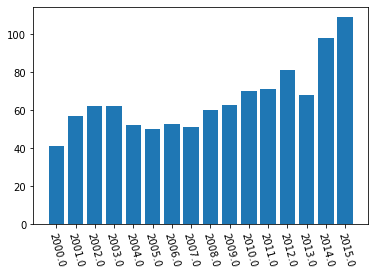

In [17]:
importlib.reload(plot_utils)

# get the number of players from each year
year_column_name = "yearID"
year_column_index = final_table.column_names.index(year_column_name)
players_per_year_dict = dict()
for row in final_table.data:
    player_year = row[year_column_index]
    if players_per_year_dict.get(player_year) is None:
        players_per_year_dict[player_year] = 1
    else:
        players_per_year_dict[player_year] += 1

# sort the data by year
sorted_keys = sorted(list(players_per_year_dict.keys()))
sorted_players_per_year_dict = dict()
for key in sorted_keys:
    sorted_players_per_year_dict[key] = players_per_year_dict[key]

# create a bar chart from the data TODO - label the chart better
plot_utils.plot_bar_chart(x_values=list(sorted_players_per_year_dict.keys()), y_values=list(sorted_players_per_year_dict.values()), 
    x_tick_labels=list(sorted_players_per_year_dict.keys()))

This bar chart shows us that we have slightly more data from recent years. This makes sense because as time progresses, professional athletes' stats are measured more carefully. We will keep this in mind when making predictions, as the predictions will be more accurate for players playing in more recent seasons.

Now, let's take a look at the number of games played for each player in our dataset so we can make sure there is a good spread of players who have played only a few games and players who have played a lot of games. We want more players with a large number of games played so thereare more accurate statistics for them. These values have been discretized already to make this process easier.

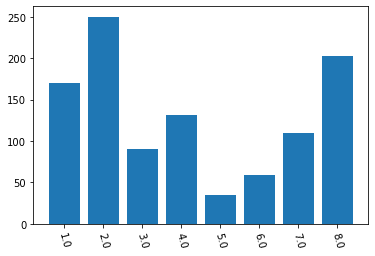

In [18]:
importlib.reload(plot_utils)

# get the number of players with each discretized value of games played
games_played_column_name = "G"
games_played_column_index = final_table.column_names.index(games_played_column_name)
players_per_games_played_dict = dict()
for row in final_table.data:
    player_games_played = row[games_played_column_index]
    if players_per_games_played_dict.get(player_games_played) is None:
        players_per_games_played_dict[player_games_played] = 1
    else:
        players_per_games_played_dict[player_games_played] += 1

# sort the data by games played
sorted_keys = sorted(list(players_per_games_played_dict.keys()))
sorted_players_per_games_played_dict = dict()
for key in sorted_keys:
    sorted_players_per_games_played_dict[key] = players_per_games_played_dict[key]

# create a bar chart from the data TODO - label the chart better
plot_utils.plot_bar_chart(x_values=list(sorted_players_per_games_played_dict.keys()), y_values=list(sorted_players_per_games_played_dict.values()), 
    x_tick_labels=list(sorted_players_per_games_played_dict.keys()))

This was not the spread of data we were expecting. Despite this, we do have the large number of players with high games played. On the other hand, there are not many players with an "average" number of games played in our dataset. These two observations tell us that the predictions might not be all that accurate for the average player, however the average player should not be an All Star, so this should not pose too much of an issue.

### Classification Results

TODO:

### Conclusion

Overall, we are happy with the solution we implemented. We were able to work with data related to a topic we enjoy, implemented a new classifier, and created a web app to show our results.  

Future work and Improvements:

* We could potentially improve classification by handling missing values better. Currently we replace missing values 0 which could have a big effect on a players stats positvely or negatively. 

* More time could be spent on developing a cleaner looking UI for the Flask app



Project Management:

* Josh was responsible for implementing our final decision-tree forest classifier. He also implemented the bonus of creating a Flask app with a basic user interface. 

* Weston was responsible for collecting data, data cleaning, and discretizing data for classification. 

Dataset Source: https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?resource=download
